In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime 
import ta
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, ParameterGrid, train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from ta.momentum import RSIIndicator
from ta.trend import SMAIndicator
from ta.volatility import BollingerBands
from datetime import datetime as dt
import joblib

## Import CSVs

In [2]:
rf_pred = pd.read_csv('prediction csv/rf_random.csv', index_col=0)
arima_pred = pd.read_csv('prediction csv/arima.csv', index_col=0)
lstm_pred = pd.read_csv('prediction csv/lstm_pred.csv', index_col=0)

## Format rf_pred

In [3]:
rf_pred.index = pd.to_datetime(rf_pred.index)

In [4]:
rf_pred.drop(columns='Residual', inplace=True)
rf_pred

,Actual,RF_pred
Date,,
2021-01-04,128.189713,133.982366
2021-01-05,128.010849,130.505458
2021-01-06,130.088043,133.982366
2021-01-07,128.120163,129.519951
2021-01-08,126.361008,130.012704
...,...,...
2021-12-17,180.330002,133.170698
2021-12-20,179.289993,130.012704
2021-12-21,179.380005,130.992063


## Format arima_pred

In [5]:
arima_pred.index = pd.to_datetime(arima_pred.index, yearfirst=True, dayfirst=True)

In [6]:
arima_pred.drop(columns='y_actual', inplace=True)

In [7]:
arima_pred.rename(columns={'arima_predicted':'arima_pred'}, inplace=True)

In [8]:
arima_pred

,arima_pred
Date,
2021-01-04,128.333703
2021-01-05,129.454595
2021-01-06,122.907843
2021-01-07,130.062883
2021-01-08,133.188385
...,...
2021-12-17,164.255411
2021-12-20,163.700089
2021-12-21,167.684540


## Format lstm_pred

In [9]:
lstm_pred.index = pd.to_datetime(lstm_pred.index)

In [10]:
lstm_pred.drop(columns='actual', inplace=True)

In [11]:
lstm_pred

,y_pred_LSTM
Date,
2021-01-04,43.178593
2021-01-05,43.134594
2021-01-06,43.155163
2021-01-07,43.321625
2021-01-08,43.455400
...,...
2021-12-17,117.532270
2021-12-20,117.589540
2021-12-21,117.620926


In [12]:
lstm_pred.rename(columns={'y_pred_LSTM':'LSTM_pred'}, inplace=True)
lstm_pred

,LSTM_pred
Date,
2021-01-04,43.178593
2021-01-05,43.134594
2021-01-06,43.155163
2021-01-07,43.321625
2021-01-08,43.455400
...,...
2021-12-17,117.532270
2021-12-20,117.589540
2021-12-21,117.620926


## Combine all dfs

In [13]:
comb_df = rf_pred.merge(arima_pred, left_on='Date', right_on="Date").merge(lstm_pred, left_on='Date', right_on='Date')
comb_df

,Actual,RF_pred,arima_pred,LSTM_pred
Date,,,,
2021-01-04,128.189713,133.982366,128.333703,43.178593
2021-01-05,128.010849,130.505458,129.454595,43.134594
2021-01-06,130.088043,133.982366,122.907843,43.155163
2021-01-07,128.120163,129.519951,130.062883,43.321625
2021-01-08,126.361008,130.012704,133.188385,43.455400
...,...,...,...,...
2021-12-17,180.330002,133.170698,164.255411,117.532270
2021-12-20,179.289993,130.012704,163.700089,117.589540
2021-12-21,179.380005,130.992063,167.684540,117.620926


## Scale features

In [14]:
#Instantiate scaler
scaler = StandardScaler()
#fit and transform features
comb_df[['RF_pred', 'arima_pred', 'LSTM_pred']] = scaler.fit_transform(comb_df[['RF_pred', 'arima_pred', 'LSTM_pred']])
#Show scaled features
comb_df

,Actual,RF_pred,arima_pred,LSTM_pred
Date,,,,
2021-01-04,128.189713,2.347368,-0.874783,-0.944059
2021-01-05,128.010849,0.259478,-0.787400,-0.946202
2021-01-06,130.088043,2.347368,-1.297777,-0.945201
2021-01-07,128.120163,-0.332320,-0.739978,-0.937093
2021-01-08,126.361008,-0.036421,-0.496318,-0.930578
...,...,...,...,...
2021-12-17,180.330002,1.859960,1.925633,2.677256
2021-12-20,179.289993,-0.036421,1.882341,2.680045
2021-12-21,179.380005,0.551686,2.192964,2.681574


## Splitting the Data 

In [15]:
train_length = len(comb_df)*0.8
test_length = len(comb_df)*0.2

In [16]:
X_train = comb_df[['RF_pred', 'arima_pred', 'LSTM_pred']][0:int(train_length)]
y_train = comb_df['Actual'][0:int(train_length)]
X_test = comb_df[['RF_pred', 'arima_pred', 'LSTM_pred']][int(train_length):]
y_test = comb_df['Actual'][int(train_length):]

## Fit linear model

In [17]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [18]:
model.score(X_test, y_test)

0.46022616896513235

In [19]:
y_pred = model.predict(X_test)

In [20]:
metrics.mean_absolute_error(y_test, y_pred)

6.451741761197745

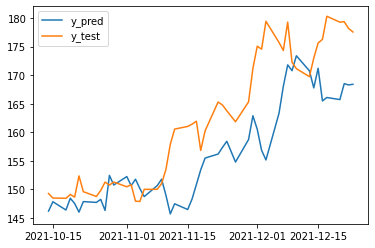

In [21]:
plt.plot(y_test.index, y_pred, label='y_pred')
plt.plot(y_test.index, y_test, label='y_test')
plt.legend()

## Without arima

In [22]:
no_arima_df = comb_df.drop(columns='arima_pred')
no_arima_df

,Actual,RF_pred,LSTM_pred
Date,,,
2021-01-04,128.189713,2.347368,-0.944059
2021-01-05,128.010849,0.259478,-0.946202
2021-01-06,130.088043,2.347368,-0.945201
2021-01-07,128.120163,-0.332320,-0.937093
2021-01-08,126.361008,-0.036421,-0.930578
...,...,...,...
2021-12-17,180.330002,1.859960,2.677256
2021-12-20,179.289993,-0.036421,2.680045
2021-12-21,179.380005,0.551686,2.681574


In [23]:
X_train_na = no_arima_df[['RF_pred', 'LSTM_pred']][0:int(train_length)]
X_test_na = no_arima_df[['RF_pred', 'LSTM_pred']][int(train_length):]

In [31]:
X_train_na

,RF_pred,LSTM_pred
Date,,
2021-01-04,2.347368,-0.944059
2021-01-05,0.259478,-0.946202
2021-01-06,2.347368,-0.945201
2021-01-07,-0.332320,-0.937093
2021-01-08,-0.036421,-0.930578
...,...,...
2021-10-07,-0.216067,0.407376
2021-10-08,-0.216067,0.439659
2021-10-11,-0.216067,0.459939


In [25]:
model = LinearRegression()
model.fit(X_train_na, y_train)

LinearRegression()

In [26]:
model.score(X_test_na, y_test)

0.7994012261180882

In [27]:
new_y_pred = model.predict(X_test_na)

In [28]:
metrics.mean_absolute_error(y_test, new_y_pred)

4.010787650538157

## Plot graph

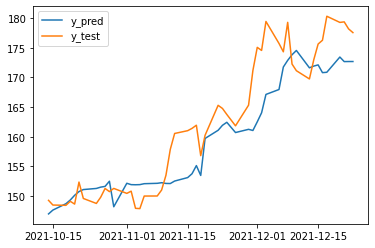

In [30]:
plt.plot(y_test.index, new_y_pred, label='y_pred')
plt.plot(y_test.index, y_test, label='y_test')
plt.legend();

## Ridge Regression

In [32]:
from sklearn import linear_model

In [33]:
reg = linear_model.Ridge(alpha=.5)
reg.fit(X_train_na, y_train)

Ridge(alpha=0.5)

In [34]:
reg.score(X_test_na, y_test)

0.790615109093911

In [35]:
reg_y_pred = reg.predict(X_test_na)

In [36]:
metrics.mean_absolute_error(y_test, reg_y_pred)

4.0809220172651735

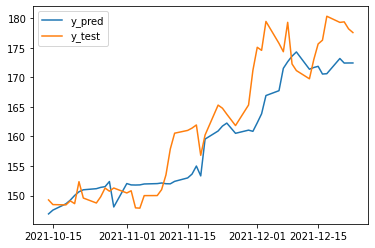

In [37]:
plt.plot(y_test.index, reg_y_pred, label='y_pred')
plt.plot(y_test.index, y_test, label='y_test')
plt.legend();